In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',1000)

In [3]:
colnames=['age','workclass','fnlwgt','edu','edunum','maritalstatus','occupation','relationship',
         'race','sex','capgain','caploss','hoursperweek','nativecountry','target']
cen=pd.read_csv('census.csv',header=None,names=colnames)
cen.head()

,age,workclass,fnlwgt,edu,edunum,maritalstatus,occupation,relationship,race,sex,capgain,caploss,hoursperweek,nativecountry,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
cen['target']=cen['target'].str.replace('<=50K','0')

In [5]:
cen['target']=cen['target'].str.replace('>50K','1')

In [6]:
cen['target']=cen['target'].astype(np.int64)
cen['target'].dtype

dtype('int64')

In [7]:
# let's make a copy of data and apply feature binning
cencopy=cen.copy()

In [8]:
df=cencopy['workclass'].value_counts()  
for i in range(len(df)):
    if df[i] < 1000:
        str=df.index[i]
        cencopy['workclass']=cencopy['workclass'].str.replace(str,'Rare')

In [9]:
df=cencopy['edu'].value_counts()  
for i in range(len(df)):
    if df[i] < 930:
        str=df.index[i]
        cencopy['edu']=cencopy['edu'].str.replace(str,'Rare')

In [10]:
# edunum and edu are same, edunum is just label encoder of edu
df=cencopy['edunum'].value_counts()  
for i in range(len(df)):
    if df.iloc[i] < 930:
        original=df.index[i]
        cencopy['edunum']=cencopy['edunum'].replace(original,0)

In [11]:
df=cencopy['maritalstatus'].value_counts()  
for i in range(len(df)):
    if df[i] < 1000:
        original=df.index[i]
        cencopy['maritalstatus']=cencopy['maritalstatus'].str.replace(original,'Rare')

In [12]:
df=cencopy['occupation'].value_counts()  
for i in range(len(df)):
    if df[i] < 1000:
        original=df.index[i]
        cencopy['occupation']=cencopy['occupation'].str.replace(original,'Rare')

In [13]:
df=cencopy['relationship'].value_counts()  
for i in range(len(df)):
    if df[i] < 2000:
        original=df.index[i]
        cencopy['relationship']=cencopy['relationship'].str.replace(original,'Rare')

In [14]:
df=cencopy['race'].value_counts()  
for i in range(len(df)):
    if df[i] < 2000:
        original=df.index[i]
        cencopy['race']=cencopy['race'].str.replace(original,'Rare')

In [15]:
df=cencopy['nativecountry'].value_counts()  
for i in range(len(df)):
    if df[i] < 200:
        original=df.index[i]
        cencopy['nativecountry']=cencopy['nativecountry'].str.replace(original,'Rare')

In [16]:
from sklearn.preprocessing import LabelEncoder
def le(df,col):
    lab=LabelEncoder()
    df[col]=pd.Series(lab.fit_transform(df[col]))

In [17]:
# we'll first drop edu, as it's already encoded
cencopy.drop('edu',axis=1,inplace=True)

In [18]:
le(cencopy,'workclass')
le(cencopy,'maritalstatus')
le(cencopy,'occupation')
le(cencopy,'relationship')
le(cencopy,'race')
le(cencopy,'sex')
le(cencopy,'nativecountry')

In [19]:
# using IQR method
def outlier(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_out=(df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
    return(df_out.sum())

def lower(df,col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower=Q1 - 1.5 * IQR
    return lower

def upper(df,col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper=Q3 + 1.5 * IQR
    return upper

def remove_outlier(df,col):
    for i in range(df.shape[0]):
        if (df[col].iloc[i])>upper(df,col):
            df[col].iloc[i]=upper(df,col)
        elif (df[col].iloc[i])<lower(df,col):
            df[col].iloc[i]=lower(df,col)

In [20]:
outlier(cencopy)

age               143
workclass        9865
fnlwgt            992
edunum           3134
maritalstatus    1434
occupation          0
relationship        0
race             4745
sex                 0
capgain          2712
caploss          1519
hoursperweek     9008
nativecountry    3391
target           7841
dtype: int64

In [21]:
from scipy.stats import zscore
z=np.abs(zscore(cencopy))
np.where(z>3)

(array([   10,    14,    15, ..., 32525, 32531, 32547], dtype=int64),
 array([11, 12, 12, ..., 12, 11, 12], dtype=int64))

In [22]:
# let's make a copy of cencopy
cencopy1=cencopy.copy()

In [23]:
cencopy1=cencopy1[(z<3).all(axis=1)]

In [24]:
xc=cencopy1.drop('target',axis=1)
yc=cencopy1['target']

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict, cross_validate
from sklearn.metrics import roc_curve, roc_auc_score

In [26]:
# Now, let's define some functions to reuse them
def fitc(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    
def get_scorec(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    train_score=m.score(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return train_score,test_score

def get_predc(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    return pred

def get_metricsc(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    acc=accuracy_score(pred,y_test)
    conf=confusion_matrix(pred,y_test)
    clas=classification_report(pred,y_test)
    return acc,conf,clas

from sklearn.model_selection import GridSearchCV
def gridcvc(m,p,x,y):
    gkb=GridSearchCV(m,p,n_jobs=-1,cv=5,scoring='accuracy')
    gkb.fit(x,y)
    return gkb.best_params_


from sklearn.model_selection import RandomizedSearchCV
def randomcvc(m,p,x,y):
    from sklearn.model_selection import RandomizedSearchCV
    gkb=RandomizedSearchCV(estimator=m,param_distributions=p,
                          cv=3,n_iter=50,
                          n_jobs=-1, verbose=5,return_train_score=True,random_state=45)
    gkb.fit(x,y)
    return gkb.best_params_

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
def bfec(m,x,y,k):
    sf=sfs(m, k_features=k, forward=False, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xbfe=x[feat_names]
    return xbfe

def ffsc(m,x,y,k):
    sf=sfs(m, k_features=k, forward=True, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xffs=x[feat_names]
    return xffs

from sklearn.decomposition import PCA
def nforpcac(x):
    pca=PCA().fit(x)
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
    plt.xlabel('No of Components')
    plt.ylabel('Variance')
    plt.axhline(y=95, color='r', linestyle='--')
    plt.show()
    
def pcac(m,x,n):
    pca=PCA(n_components=n)
    xpca=pd.DataFrame(pca.fit_transform(x))
    return xpca

def crossc(m,x,y,c=5):
    score=cross_val_score(m,x,y,cv=c,n_jobs=-1)
    return (score.mean(), score.std())

from sklearn.preprocessing import StandardScaler
def stdc(x):
    scx=StandardScaler()
    xs=pd.DataFrame(scx.fit_transform(x), columns=x.columns)
    return xs

from sklearn.preprocessing import MinMaxScaler
def mmc(x):
    mm=MinMaxScaler()
    xm=pd.DataFrame(mm.fit_transform(x), columns=x.columns)
    return xm

def modified_bfec(m,x,y,k):
    sf=sfs(m, k_features=k, forward=False, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xbfe=x[feat_names]
    x_train, x_test, y_train, y_test=train_test_split(xbfe,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return test_score

def modified_ffsc(m,x,y,k):
    sf=sfs(m, k_features=k, forward=True, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xffs=x[feat_names]
    x_train, x_test, y_train, y_test=train_test_split(xffs,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return test_score

def modified_pcac(m,x,y,n):
    pca=PCA(n_components=n)
    xpca=pd.DataFrame(pca.fit_transform(x))
    x_train, x_test, y_train, y_test=train_test_split(xpca,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return test_score

def ttsc(x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    return x_train, x_test, y_train, y_test

def classification(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    clas=classification_report(pred,y_test)
    return clas

In [27]:
lrc=LogisticRegression(n_jobs=-1,random_state=45)
dtc=DecisionTreeClassifier(random_state=45)
svc=SVC(random_state=45)
knnc=KNeighborsClassifier(n_jobs=-1)
rfc=RandomForestClassifier(n_jobs=-1,random_state=45)
gbc=GradientBoostingClassifier(random_state=45)
xgbc=XGBClassifier(n_jobs=-1,random_state=45)
adac=AdaBoostClassifier(random_state=45)
gnb=GaussianNB()
mnb=MultinomialNB()

In [28]:
xc.shape

(28013, 13)

In [29]:
yc.shape

(28013,)

In [30]:
# xgb with xc 0.9129038731687739, 0.8615500376222723

In [31]:
# Individual Model Pipeline:
# 1. feature selection
# 2. Hyper parameter tuning
# 3. Boosting
# 4. Cross Validation
# 5. Evaluation Metrics

In [32]:
# xgbc=XGBClassifier(n_jobs=-1,random_state=45)

In [32]:
# lets apply PCA
# n from 9 to 13
for i in range(9,13):
        print(i," ",modified_pcac(xgbc,xc,yc,i))

9   0.8498001142204454
10   0.855225585379783
11   0.855653912050257
12   0.857367218732153


In [33]:
# we won't use PCA

In [34]:
# lets apply tuning

In [37]:
XGBClassifier?

In [38]:
param_xgb={'max_depth':[2,4,6,8],'learning_rate':[0.01,0.1,1],'min_child_weight':[1,2,4,6]}
randomcvc(xgbc,param_xgb,xc,yc)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  3.8min finished


{'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1}

In [39]:
param_xgb1={'max_depth':[4,5,6,7,8],'learning_rate':[0.05,0.1,0.2,0.4],'min_child_weight':[1,2,3]}
randomcvc(xgbc,param_xgb1,xc,yc)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.2min finished


{'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1}

In [33]:
xgbc1=XGBClassifier(n_jobs=-1,random_state=45,min_child_weight=3, max_depth= 6, learning_rate= 0.1)

In [41]:
get_scorec(xgbc1,xc,yc)

(0.8827169308391641, 0.8627926898914906)

In [42]:
# the score improved a little

In [43]:
# lets cross validate it
crossc(xgbc1,xc,yc)

(0.8662051549244637, 0.0057749710719799275)

In [44]:
# lets use a for loop 
for i in range(3,12):
    print(crossc(xgbc1,xc,yc,i))

(0.8659908329774586, 0.0029247136095750114)
(0.864741561970708, 0.004400193356904525)
(0.8662051549244637, 0.0057749710719799275)
(0.8660263683190844, 0.005704133829834493)
(0.8662769558370346, 0.005177408027216753)
(0.8657773934392514, 0.006073782623371257)
(0.8667769174293087, 0.006491468347698628)
(0.8665265675465802, 0.006264117824902675)
(0.8655989271675288, 0.006278592202279568)


In [45]:
# best score at cv=9

In [46]:
# the score improved

In [48]:
# lets predict the score
crosspred=cross_val_predict(xgbc1,xc,yc)

In [53]:
# lets get the metrics

In [54]:
classi=classification_report(yc,crosspred)
conf=confusion_matrix(yc,crosspred)
acc=accuracy_score(yc,crosspred)
print(acc)
print(' ')
print(conf)
print(' ')
print(classi)

0.8659907899903616
 
[[20660  1168]
 [ 2586  3599]]
 
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     21828
           1       0.75      0.58      0.66      6185

    accuracy                           0.87     28013
   macro avg       0.82      0.76      0.79     28013
weighted avg       0.86      0.87      0.86     28013



In [56]:
# lets check metrics of xgbc1,xc,yc
# Evaluation metrics
acc, conf, clas=get_metricsc(xgbc1,xc,yc)
print(acc)
print(' ')
print(conf)
print(' ')
print(clas)

0.8627926898914906
 
[[5152  655]
 [ 306  891]]
 
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      5807
           1       0.58      0.74      0.65      1197

    accuracy                           0.86      7004
   macro avg       0.76      0.82      0.78      7004
weighted avg       0.88      0.86      0.87      7004



In [58]:
# lets save the cross validated model
cv_results = cross_validate(xgbc, xc ,yc, cv=9, return_estimator=True)
xgbc_fit = cv_results['estimator']
print(xgbc_fit)

(XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=45, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None), XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_est

In [59]:
xgbc_fit=xgbc_fit[0]

In [60]:
import joblib
joblib.dump(xgbc_fit,'xgbc_cencus.pkl')

['xgbc_cencus.pkl']

In [61]:
# saving predictions
prediction=pd.DataFrame(crosspred)
prediction.to_csv('prediction_cencus.csv')

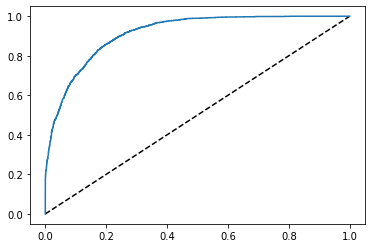

In [36]:
# auc_roc
xtr,xte,ytr,yte=ttsc(xc,yc)
xgbc1.fit(xtr,ytr)
y_pred_pro=xgbc1.predict_proba(xte)[:,1]
fpr,tpr,threshold=roc_curve(yte,y_pred_pro)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr,tpr,label='LRC')
plt.show()

In [37]:
roc_auc_score(yte,y_pred_pro)

0.9137579834625651